In [1]:
from io import StringIO
from pdfminer import pdfpage
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfpage import PDFPage
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageFont, ImageDraw
import camelot

pd.set_option('display.max_colwidth', None)

In [2]:

def make_df_image(table,
                  max_cols=-1,
                  max_rows=-1):
    """Return dataframe as image."""
    with tempfile.NamedTemporaryFile(suffix='.jpg',
                                     delete=False) as tmp:
        dfi.export(table, tmp.name, max_cols=max_cols, max_rows=max_rows)
        image = mpimg.imread(tmp.name)
        return image


def make_lines_image(lines,
                     mrgn=15,
                     background=(255, 255, 255),
                     text_color=(0, 0, 0),
                     font_size=10):
    """Return raw text in lines as image."""
    lines = pd.Series(lines)
    longest_line = lines[lines.str.len().idxmax()]
    image = Image.new("RGBA", (1, 1))
    draw = ImageDraw.Draw(image)
    monospace = ImageFont.truetype(r'С:\Windows\Fonts\cour.ttf', font_size)
    line_width, line_height = draw.textsize(longest_line, monospace)
    img_width, img_height = (line_width + mrgn * 2,
                             len(lines) * line_height + mrgn * 2)
    image = Image.new("RGBA", (img_width, img_height), background)
    draw = ImageDraw.Draw(image)
    x, y0 = (mrgn, mrgn)
    for n, line in enumerate(lines):
        y = y0 + n * line_height
        draw.text((x, y), line, text_color, monospace)
    return image


In [3]:
def extract(extract_no):
    pdfminer_string = StringIO()
    pageno = 0
    with open(PDF, "rb") as in_file:
        parser = PDFParser(in_file)
        doc = PDFDocument(parser)
        rsrcmgr = PDFResourceManager()
        device = TextConverter(rsrcmgr,
                            pdfminer_string,
                            laparams=LAParams())
        interpreter = PDFPageInterpreter(rsrcmgr, device)
        for page in PDFPage.create_pages(doc):
            if pageno == extract_no:
                interpreter.process_page(page)
            pageno = pageno+1
        # pdfminer_lines = pdfminer_string.getvalue().splitlines()
    pdfminer_lines = [ln for ln in pdfminer_lines if ln]
    return pdfminer_lines

def camel(extract_no):
    # layout_kwargs={'char_margin':0.1, 'line_margin':2, 'boxes_flow':1}
    tables, text = camelot.read_pdf(PDF, strip_text='\n', pages=str(extract_no), backend="poppler", split_text=True, process_background=False, copy_text=['h','v'], line_scale=60)
    camelot.plot(tables[0], kind='line')
    tables.export(r'C:\Data\Output\tables\table.csv', f='csv', compress=True) # json, excel, html, markdown, sqlite
    print(tables.export(r'C:\Data\Output\tables\table.txt',f='txt'))
    tablesfin, line, dic, header = [], '', {}, 0
    '''                                              Testing new logic below / / / /
    for table in text:
        para = []
        for row_index,row in enumerate(table):
            for col_index,col in enumerate(row):
                if len(table[0][col_index]) > 2:
                    print(f'/-------{table[0][col_index]}|-------|')
                    if row_index > 0:
                        line = f'{table[0][col_index]} - {col}, '
                else:
                    if row_index > 1:
                        line = f'{table[1][col_index]} - {col}, '
                print(f'\n{line}')
                para.append(line)
        tabel = ' '.join(para)
        tablesfin.append(tabel)
    for table in tablesfin:
        print(f'\n\n\n ///// After sentencing logic ///// \n{table}\n')
    '''
    for table in text:
        para = []
        for row_index,row in enumerate(table):
            for col_index,col in enumerate(row):
                dic.setdefault(f'Col{col_index}', [])
                if row_index <= header:
                    if table[row_index][col_index] not in dic.get(f'Col{col_index}', ''):
                        dic[f'Col{col_index}'].append(table[row_index][col_index])
                if table[row_index][col_index] in dic.get(f'Col{col_index}', ''):
                    header = row_index
                else:
                    head = ' '.join(dic.get(f'Col{col_index}', ''))
                    line = f'{head} - {table[row_index][col_index]},'
                print(f'\n{line}')
                para.append(line)
            para.append('\n')
        tabel = ' '.join(para)
        tablesfin.append(tabel)
    for table in tablesfin:
        print(f'\n\n\n ///// After sentencing logic ///// \n{table}\n')
        
'''
REPLACE IN core.py in camelot package:

    def to_txt(self, **kwargs):
        """Prints as raw text.

        For kwargs, check :meth:`pandas.DataFrame.to_string`.

        Parameters
        ----------
        path : str
            Output filepath.

        """
        rawtxt = {"encoding": "utf-8", "index": False, "header": False, "quoting": csv.QUOTE_NONE, "doublequote": False, "escapechar":'?', "sep":' '}
        text = self.df.to_csv(**rawtxt).replace('?', '')
        #print(text)
        return(text)
        
        def export(self, path, f="csv", compress=False):
        """Exports the list of tables to specified file format.

        Parameters
        ----------
        path : str
            Output filepath.
        f : str
            File format. Can be csv, excel, html, json, markdown or sqlite.
        compress : bool
            Whether or not to add files to a ZIP archive.

        """
        dirname = os.path.dirname(path)
        basename = os.path.basename(path)
        root, ext = os.path.splitext(basename)
        if compress:
            dirname = tempfile.mkdtemp()

        kwargs = {"path": path, "dirname": dirname, "root": root, "ext": ext}

        if f in ["csv", "html", "json", "markdown"]:
            self._write_file(f=f, **kwargs)
            if compress:
                self._compress_dir(**kwargs)
        elif f == "excel":
            filepath = os.path.join(dirname, basename)
            writer = pd.ExcelWriter(filepath)
            for table in self._tables:
                sheet_name = f"page-{table.page}-table-{table.order}"
                table.df.to_excel(writer, sheet_name=sheet_name, encoding="utf-8")
            writer.save()
            if compress:
                zipname = os.path.join(os.path.dirname(path), root) + ".zip"
                with zipfile.ZipFile(zipname, "w", allowZip64=True) as z:
                    z.write(filepath, os.path.basename(filepath))
        elif f == "sqlite":
            filepath = os.path.join(dirname, basename)
            for table in self._tables:
                table.to_sqlite(filepath)
            if compress:
                zipname = os.path.join(os.path.dirname(path), root) + ".zip"
                with zipfile.ZipFile(zipname, "w", allowZip64=True) as z:
                    z.write(filepath, os.path.basename(filepath))
        elif f == "txt":
            for table in self._tables:
                text = table.to_txt()
                return text
'''                       

'\nREPLACE IN core.py in camelot package:\n\n    def to_txt(self, **kwargs):\n        """Prints as raw text.\n\n        For kwargs, check :meth:`pandas.DataFrame.to_string`.\n\n        Parameters\n        ----------\n        path : str\n            Output filepath.\n\n        """\n        rawtxt = {"encoding": "utf-8", "index": False, "header": False, "quoting": csv.QUOTE_NONE, "doublequote": False, "escapechar":\'?\', "sep":\' \'}\n        text = self.df.to_csv(**rawtxt).replace(\'?\', \'\')\n        #print(text)\n        return(text)\n        \n        def export(self, path, f="csv", compress=False):\n        """Exports the list of tables to specified file format.\n\n        Parameters\n        ----------\n        path : str\n            Output filepath.\n        f : str\n            File format. Can be csv, excel, html, json, markdown or sqlite.\n        compress : bool\n            Whether or not to add files to a ZIP archive.\n\n        """\n        dirname = os.path.dirname(path)

In [4]:
def extracted(pdfminer_lines):
    # pd.Series(pdfminer_lines)
    fig, ax = plt.subplots(figsize=(50,25))
    title = 'pdfminer.six 20201018'
    for i,img in enumerate(map(make_lines_image,
                                [pdfminer_lines])):
        ax.axis("off")
        ax.set_adjustable("box")
        ax.title.set_text(title)
        ax.imshow(img)
    return fig.tight_layout()

Plant Type Surface in contact with or exposed to  Plant Part Surface prep. grade Shop and Site Coats Shop and Site Coats Shop and Site Coats Shop and Site Coats Shop and Site Coats Shop and Site Coats Total dry film thickness µm Shop coating system
Plant Type Surface in contact with or exposed to  Plant Part Surface prep. grade Primer Primer Primer Top-Coat Top-Coat Top-Coat Total dry film thickness µm Shop coating system
Plant Type   Plant Part Surface prep. grade Type No. Dry film thickness µm/coat Type No. Dry film thickness µm/coat Total dry film thickness µm Shop coating system
 Potable Outside  2.5 X 2 40 B 3 80 320 T1
Water Systems Potable Inside Vessels, tanks 2.5 X 2 40 N 3 100 380 T4
Water Systems Water  Filter vessels 3 X 2 40 H 3 110 410 T4
Water Systems Atmosphere Outside, outdoor or indoor exposure Vessels, tanks, steel structures, machinery 2.5 X 2 40 B 3 80 320 T2
 Atmosphere outside dry, indoor exposure Steel structures 2 Y 2 40 A 3 45 215 T2
Drainage Systems Sewer wat

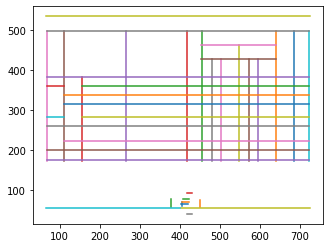

In [5]:
filename='nepal'
PDF = f'file:///C:/Data/test/{filename}.pdf'
pagen = 142
#lines = extract(pagen)
camel(pagen)
#extracted(lines)